## Data extraction

In [165]:
import re
import numpy as np


In [25]:
with open('relax.out', 'r') as f:
    file = f.read()

In [73]:
###only select part 4 of the data
a=re.split(r'4.  RESULTS',file)[1]
b=re.split(r'5.  TIMINGS',a)[0]
##exclude the averaged data
data=re.split(r'A V E R A G E S',b)[0]
data

'\n--------------------------------------------------------------------------------\n\n| MC Barostat: Decreasing size of volume moves\n\n NSTEP =     2500   TIME(PS) =      45.000  TEMP(K) =   296.41  PRESS =     0.0\n Etot   =    -26402.3678  EKtot   =      5990.3599  EPtot      =    -32392.7276\n BOND   =        12.2374  ANGLE   =        35.8290  DIHED      =        35.7643\n 1-4 NB =         5.9399  1-4 EEL =      -242.3696  VDWAALS    =      4941.1030\n EELEC  =    -37181.2315  EHBOND  =         0.0000  RESTRAINT  =         0.0000\n EKCMT  =         0.0000  VIRIAL  =         0.0000  VOLUME     =    103115.3627\n                                                    Density    =         0.9834\n ------------------------------------------------------------------------------\n\n| MC Barostat: Decreasing size of volume moves\n\n NSTEP =     5000   TIME(PS) =      50.000  TEMP(K) =   294.29  PRESS =     0.0\n Etot   =    -26620.6004  EKtot   =      5947.5962  EPtot      =    -32568.1966\n 

extract data and convert data type

In [199]:
#time
TIME=re.findall(r'TIME\(PS\) =\s+(\d+)',data)
TIME=np.array(TIME).astype(float)

In [259]:
##Etotal
Etotal=re.findall(r'Etot   =\s+(-\d+.\d+)',data)
Etotal=np.array(Etotal).astype(float)
#EKtot
EKtot=re.findall(r'EKtot   =\s+(\d+.\d+)',data)
EKtot=np.array(EKtot).astype(float)
#EPtot
EPtot=re.findall(r'EPtot\s+=\s+(-\d+.\d+)',data)
EPtot=np.array(EPtot).astype(float)

In [185]:
#VOLUME
VOLUME=re.findall(r'VOLUME\s+=\s+(\d+.\d+)',data)
VOLUME=np.array(VOLUME).astype(float)
#Density
Density=re.findall(r'Density\s+=\s+(\d+.\d+)',data)
Density=np.array(Density).astype(float)

array([0.9834, 0.9874, 0.9859, ..., 0.9918, 0.9796, 0.9892])

ignore the following part:

In [169]:
#BOND
BOND=re.findall(r' BOND\s+=\s+(\d+.\d+)',data)
BOND=np.array(BOND).astype(float)
#ANGLE
Angle=re.findall(r' ANGLE\s+=\s+(\d+.\d+)',data)
Angle=np.array(Angle).astype(float)
#DIHED
DIHED=re.findall(r' DIHED\s+=\s+(\d+.\d+)',data)
DIHED=np.array(DIHED).astype(float)
#1-4 NB
NB=re.findall(r' 1-4 NB\s+=\s+(\d+.\d+)',data)
NB=np.array(NB).astype(float)
#1-4 EEL
EEL=re.findall(r' 1-4 EEL\s+=\s+(-\d+.\d+)',data)
EEL=np.array(EEL).astype(float)
#VDWAALS   
VDWAALS=re.findall(r' VDWAALS\s+=\s+(\d+.\d+)',data)
VDWAALS=np.array(VDWAALS).astype(float)
#EELEC
EELEC=re.findall(r' EELEC\s+=\s+(-\d+.\d+)',data)
EELEC=np.array(EELEC).astype(float)
#EHBOND---0？
EHBOND=re.findall(r' EHBOND\s+=\s+(\d+.\d+)',data)
EHBOND=np.array(EHBOND).astype(float)
#RESTRAINT---0
RESTRAINT=re.findall(r' RESTRAINT\s+=\s+(\d+.\d+)',data)
RESTRAINT=np.array(RESTRAINT).astype(float)

## Visualization

In [166]:
import matplotlib as mpl
import matplotlib.pyplot as plt

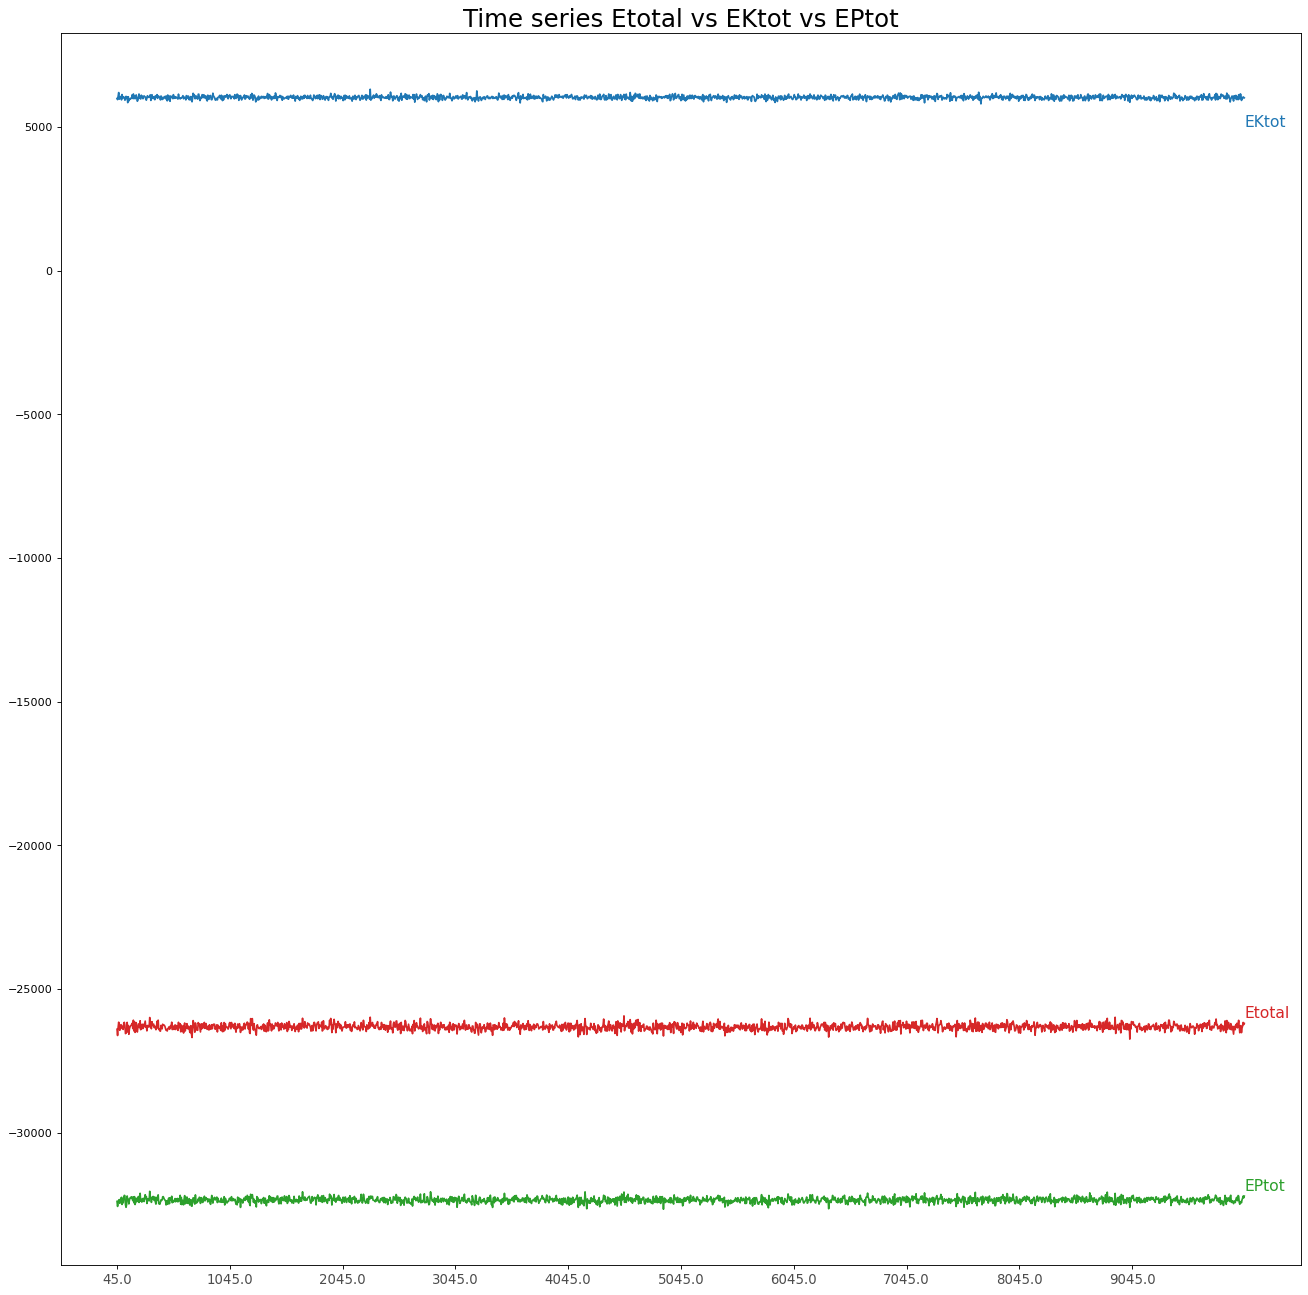

In [244]:
##Etotal
plt.figure(figsize=(20,20),dpi=80)
plt.plot(TIME,Etotal,c='tab:red')
plt.text(TIME[-1],-26000 , "Etotal", fontsize=14, color='tab:red')
plt.plot(TIME,EKtot,c='tab:blue')
plt.text(TIME[-1],5000 , "EKtot", fontsize=14, color='tab:blue')
plt.plot(TIME,EPtot,c='tab:green')
plt.text(TIME[-1],-32000 , "EPtot", fontsize=14, color='tab:green')
#Decoration
xtick_location=TIME[::200]
plt.title("Time series Etotal vs EKtot vs EPtot", fontsize=22)
plt.xticks(ticks=xtick_location, labels=xtick_location, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.show()

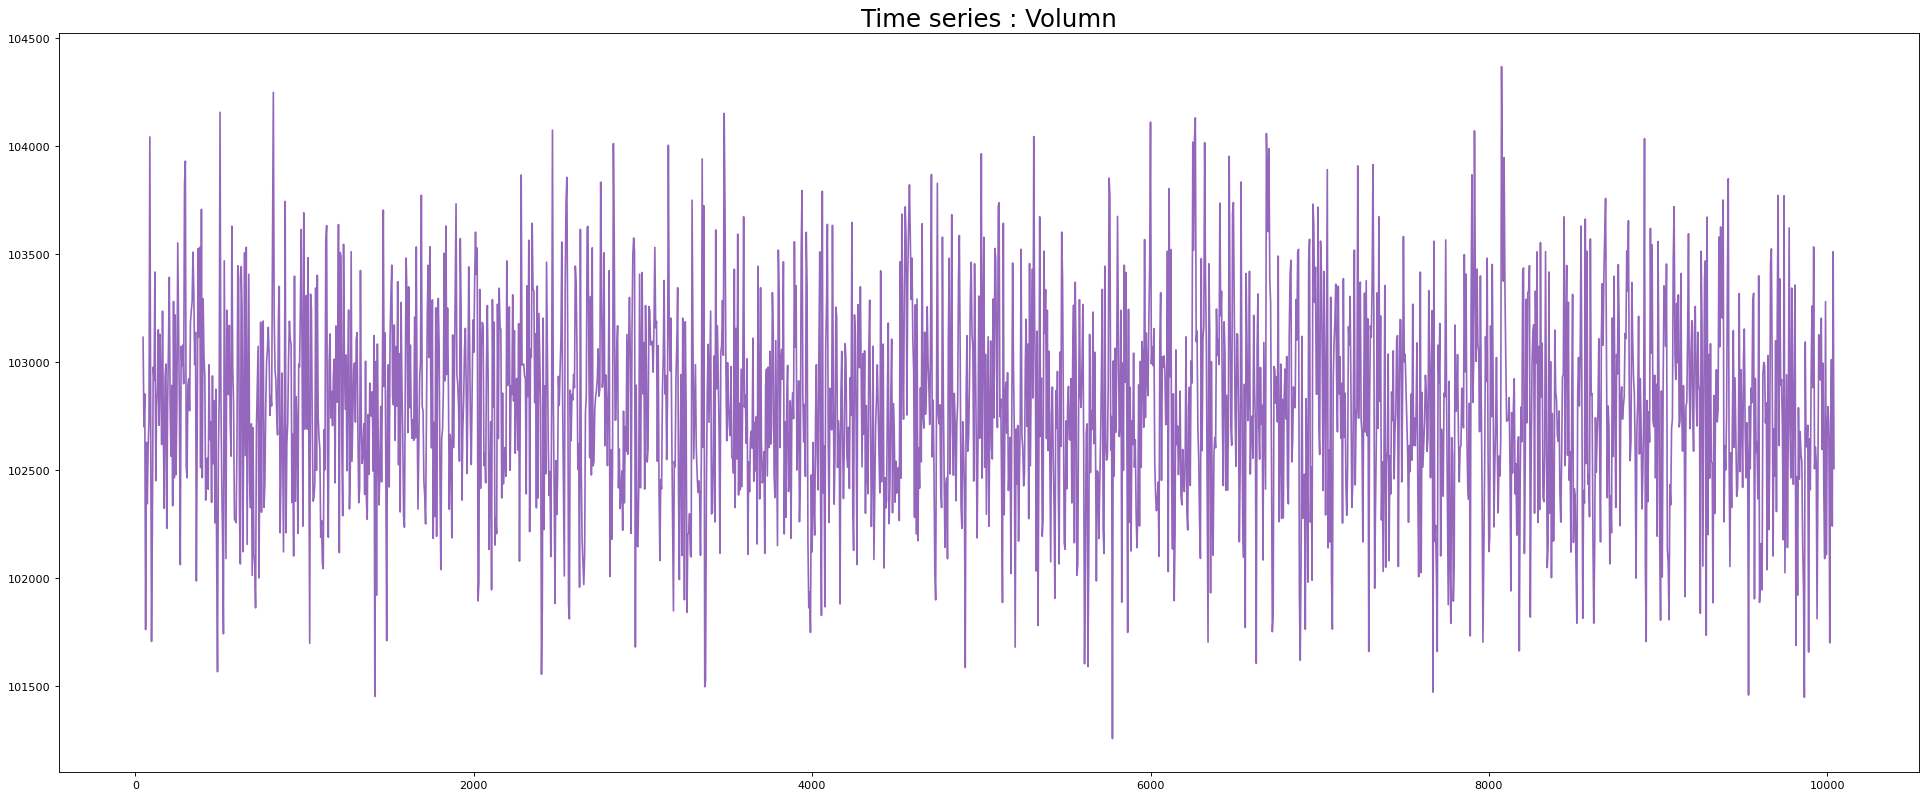

In [242]:
##volumn
plt.figure(figsize=(30,12),dpi=80)
plt.plot(TIME,VOLUME,c='tab:purple')
plt.title("Time series : Volumn", fontsize=22)
plt.show()

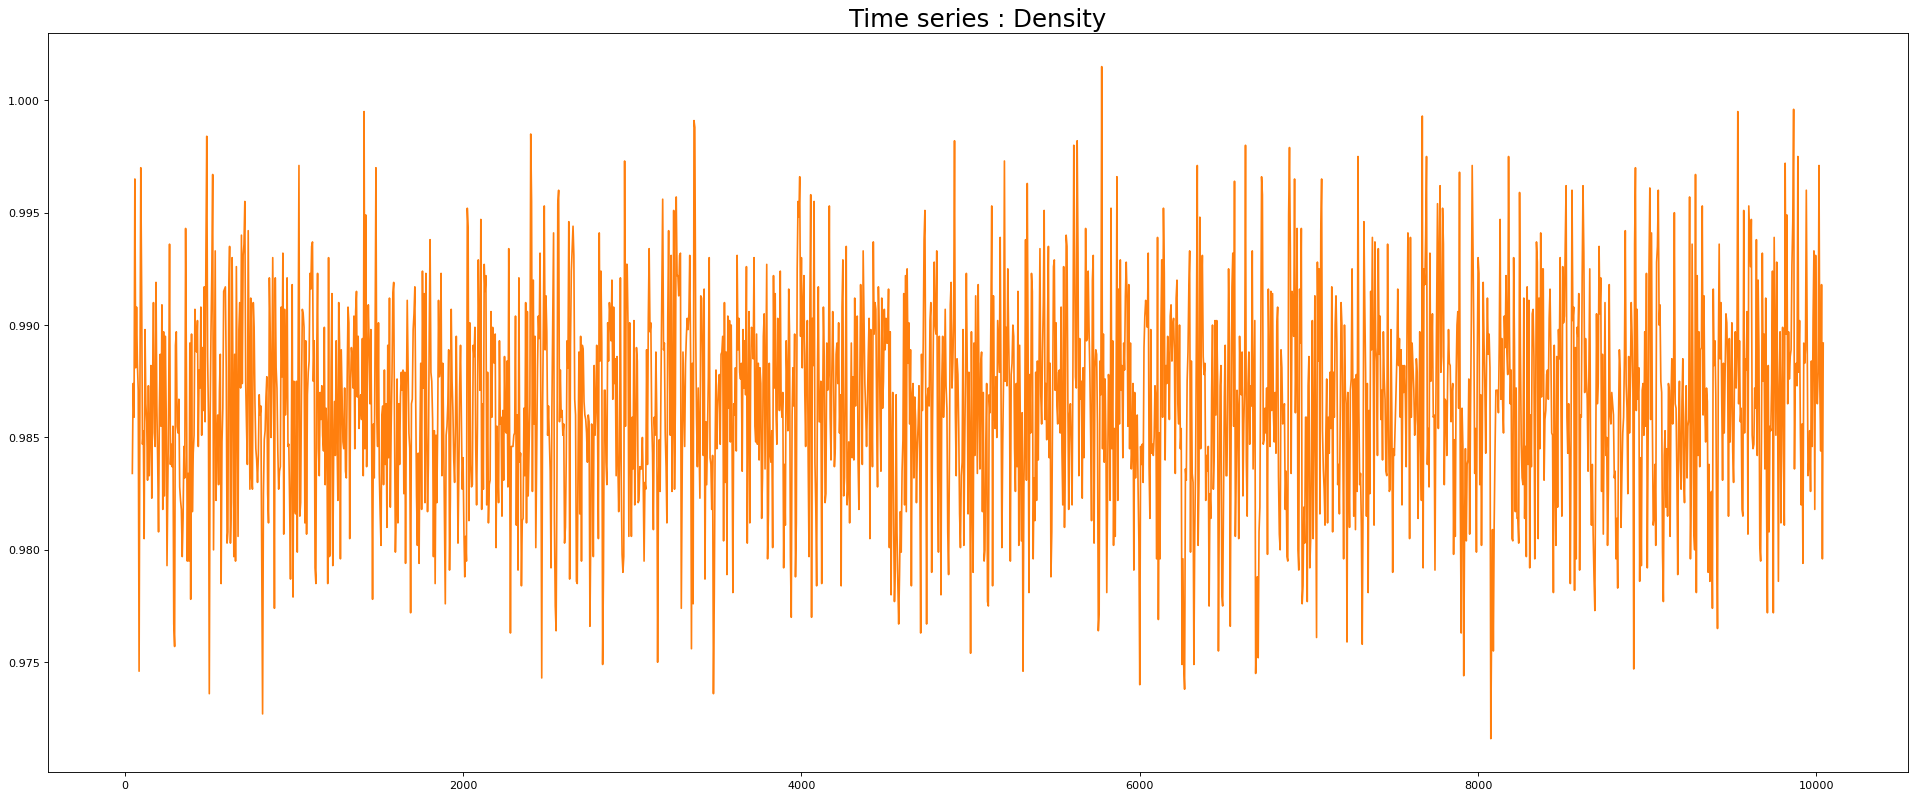

In [243]:
##density
plt.figure(figsize=(30,12),dpi=80)
plt.plot(TIME,Density,c='tab:orange')
plt.title("Time series : Density", fontsize=22)
plt.show()

## Compute the correlated time tau and inefficacy g

In [254]:
##borrow from "correlated time series data" document
import math
import warnings
import numpy as np
import numpy.linalg
def corr_time(A_n,B_n=None,mintime=3):

    N=A_n.size

    #initiate g
    g=1.0
    if B_n is None:
         B_n=np.array(A_n)

    mu_A=A_n.mean()
    mu_B=B_n.mean()

    # Make temporary copies of fluctuation from mean.
    dA_n = A_n.astype(np.float64) - mu_A
    dB_n= B_n.astype(np.float64) - mu_B
    ##denominator of Ct
    
    sigma2_AB=(dA_n*dB_n).mean()
   
    ######key part
    t=1
    while (t<N-1):
        C=np.sum(dA_n[0:(N-t)]*dB_n[t:N] + dB_n[0:(N - t)] * dA_n[t:N])/(2*float(N-t)*sigma2_AB)
        
        ## terminates if the correlatoin function goes negative
        
        if (C <= 0.0) and (t > mintime):
            break
                  
        g += 2.0 * C * (1.0 - float(t) / float(N))
      
        t += 1        
    
     #g must be at least unity
    if (g < 1.0):
        g = 1.0
    tau=(g-1)/2
    return g,tau



In [264]:
#Etot
g=corr_time(Etotal)[0]
tau=corr_time(Etotal)[-1]
print("statistical Inefficiency is {}".format(g))
print("autocorrelated time is {}".format(tau))

statistical Inefficiency is 1.051643443142959
autocorrelated time is 0.02582172157147955


In [265]:
#EKtot
g=corr_time(EKtot)[0]
tau=corr_time(EKtot)[-1]
print("statistical Inefficiency is {}".format(g))
print("autocorrelated time is {}".format(tau))

statistical Inefficiency is 1.0
autocorrelated time is 0.0


In [266]:
#EPtot
g=corr_time(EPtot)[0]
tau=corr_time(EPtot)[-1]
print("statistical Inefficiency is {}".format(g))
print("autocorrelated time is {}".format(tau))

statistical Inefficiency is 1.0676577737716564
autocorrelated time is 0.03382888688582819


In [257]:
#Volumn
g=corr_time(VOLUME)[0]
tau=corr_time(VOLUME)[-1]
print("statistical Inefficiency is {}".format(g))
print("autocorrelated time is {}".format(tau))

statistical Inefficiency is 1.3648823728515735
autocorrelated time is 0.18244118642578677


In [267]:
#Density
g=corr_time(Density)[0]
tau=corr_time(Density)[-1]
print("statistical Inefficiency is {}".format(g))
print("autocorrelated time is {}".format(tau))

statistical Inefficiency is 1.3634270310759766
autocorrelated time is 0.1817135155379883
